# Problem Statement

#### You are working for a new-age insurance company and employ mutiple outreach plans to sell term insurance to your customers. Telephonic marketing campaigns still remain one of the most effective way to reach out to people however they incur a lot of cost. Hence, it is important to identify the customers that are most likely to convert beforehand so that they can be specifically targeted via call. We are given the historical marketing data of the insurance company and are required to build a ML model that will predict if a client will subscribe to the insurance. 

### Features: 
age (numeric)

job : type of job

marital : marital status

educational_qual : education status

call_type : contact communication type

day: last contact day of the month (numeric)

mon: last contact month of year

dur: last contact duration, in seconds (numeric)

num_calls: number of contacts performed during this campaign and for this client 

prev_outcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

Output variable (desired target):
y - has the client subscribed to the insurance?

### Minimum Requirements

It is not sufficient to just fit a model - the model must be analysed to find the important factors that contribute towards the conversion rate. AUROC must be used as a metric to evaluate the performance of the models. 


# Import Statements

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import typing as ty

from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

## Loading the dataset

In [130]:
df = pd.read_csv("/train.csv")


In [131]:
#Cheaking if there exists np.nan
df.isna().any()

age               False
job               False
marital           False
education_qual    False
call_type         False
day               False
mon               False
dur               False
num_calls         False
prev_outcome      False
y                 False
dtype: bool

Missing values are handled in non-standardized way.

### 1. Understanding the basic nature of the data

In [132]:
df.head()

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y
0,58,management,married,tertiary,unknown,5,may,261,1,unknown,no
1,44,technician,single,secondary,unknown,5,may,151,1,unknown,no
2,33,entrepreneur,married,secondary,unknown,5,may,76,1,unknown,no
3,47,blue-collar,married,unknown,unknown,5,may,92,1,unknown,no
4,33,unknown,single,unknown,unknown,5,may,198,1,unknown,no


In [133]:
df.shape

(45211, 11)

#### Basic Analysis of continuous features


In [134]:
df.describe()

,age,day,dur,num_calls
count,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,15.806419,258.163080,2.763841
std,10.618762,8.322476,257.527812,3.098021
min,18.000000,1.000000,0.000000,1.000000
25%,33.000000,8.000000,103.000000,1.000000
50%,39.000000,16.000000,180.000000,2.000000
75%,48.000000,21.000000,319.000000,3.000000
max,95.000000,31.000000,4918.000000,63.000000


The age group that mostly contacted are range of 30 - 50 adults.

Duration is right skewed, talking to customers is essential feature for conversation dataset. By general knowledge, people who interested speak more are likely to convert. If the feature is skewed there is a possibility of **Imbalanced** dataset.

Most people contacted in range of 0 - 6 times

#### Basic Analysis of categorical features

In [135]:
if sorted(df["day"].unique()) == [i for i in range(1,32)]:
  print("Contact has been made every day of the month, mean makes sense.")
else:
  print("No")

Contact has been made every day of the month, mean makes sense.


The most customers has a last point of contact in range of 7th - 23rd day of the month.


In [136]:
df["job"].value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64



*   Each class in job categorical variable indeed divided into various subclasses
*  Expect blue-collar there is general decreasing trend of prestige level of jobs, which implies generally there is decreasing trend of the amount of money each professional earns.



In [137]:
df["marital"].value_counts()

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

The most people who is the age group of 30 - 50, generally the most people are married at this age.

The majority of the customers in the dataset are married, followed by single and divorced individuals. This suggests that married individuals may be more likely to respond to marketing campaigns than single or divorced individuals. (this may be cause less population of singles and divorced.)

In [138]:
df["education_qual"].value_counts()

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education_qual, dtype: int64

Blue collar jobs, unemployed, students, housemaid tend to have lower level of education so maybe it captured in education qual.

Management folks and other white collar jobs tend to do higher education, may be tertiary count here describes that.

In [139]:
df['call_type'].value_counts()

cellular     29285
unknown      13020
telephone     2906
Name: call_type, dtype: int64

Majority of the customers were contacted via cellular phones, while a significant proportion of the customers had an unknown call type.

In [140]:
df["prev_outcome"].value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: prev_outcome, dtype: int64

Though the previously converted people may have high conversation rates **provided their insurance plan is already over** - must be the case. Here there is no way make any plausible conclusion because there is more than 60% of data is missing.

In [141]:
df["mon"].value_counts()

may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: mon, dtype: int64

Most where contacted in middle months of year.

This could suggest that the marketing campaign may be launched in May and continued with great zeal into following months.

In [142]:
df.tail()

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y
45206,51,technician,married,tertiary,cellular,17,nov,977,3,unknown,yes
45207,71,retired,divorced,primary,cellular,17,nov,456,2,unknown,yes
45208,72,retired,married,secondary,cellular,17,nov,1127,5,success,yes
45209,57,blue-collar,married,secondary,telephone,17,nov,508,4,unknown,no
45210,37,entrepreneur,married,secondary,cellular,17,nov,361,2,other,no


#### Basic analysis of target variable

Target variable y is a binary categorical variable. Predicting the customer conversion based on given features.

Checking the dataset if it is a imbalanced dataset


In [143]:
#Renaming y to appropriate feature name

df.rename(columns={"y":"cus_converted"},inplace=True)
df.head(1)

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,cus_converted
0,58,management,married,tertiary,unknown,5,may,261,1,unknown,no


In [144]:
# Checking missing values in target variable
df["cus_converted"].unique()

array(['no', 'yes'], dtype=object)

In [145]:
#Checking if it is imbalanced dataset
(df["cus_converted"].value_counts()/df.shape[0])*100


no     88.30152
yes    11.69848
Name: cus_converted, dtype: float64

Dataset is imbalanced dataset. Up-scaling must be done to balance the data before modeling.

##### Encoding the target variable.

In [146]:
cus_converted_Encoded = df['cus_converted'].map({"yes":1,"no":0})
df["cus_converted"] = cus_converted_Encoded

In [147]:
df["cus_converted"].unique()

array([0, 1])

### 2. Data preprocessing


##### Helper functions


In [148]:
class resMinMaxOD(ty.TypedDict):
    min:float;
    max:float

def maxNMinForOutlierDeduction(feature:pd.Series,clipNReturn:bool = True,maintainInt:bool = False) -> ty.Union[resMinMaxOD,pd.Series]:
    q1,q3 = np.percentile(feature,[25,75])
    iqr = q3 - q1
    minThreshold = q1 - (1.5*iqr)
    maxThreshold = q3 + (1.5*iqr)
    if(maintainInt == True):
        minThreshold = int(round(minThreshold))
        maxThreshold = int(round(maxThreshold))
    if(clipNReturn == False):
        return {
            'max':maxThreshold,
            'min':minThreshold
        }
    else:
        clippedSeries = feature.clip(lower=minThreshold,upper=maxThreshold)
        return clippedSeries

In [149]:
def showBoxPlot(feature:pd.Series,title:str = "",xlabel:str = ""):
    sns.boxplot(x=feature)
    if(len(title)>0):
        plt.title(title)
    if(len(xlabel)>0):
        plt.xlabel(xlabel)
    plt.show()


In [150]:
def showPercentageOfMissingValues(feature:pd.Series,labelRepresentingUnknownValue:ty.Union[str,int,float] = "unknown",tot:int = 45211) -> float:
    """
    Returns the percentage of missing values in a feature.
    """
    con = feature == labelRepresentingUnknownValue
    return (con.sum()/tot)*100



#### Processing continuous features

In [151]:
df.head()

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,cus_converted
0,58,management,married,tertiary,unknown,5,may,261,1,unknown,0
1,44,technician,single,secondary,unknown,5,may,151,1,unknown,0
2,33,entrepreneur,married,secondary,unknown,5,may,76,1,unknown,0
3,47,blue-collar,married,unknown,unknown,5,may,92,1,unknown,0
4,33,unknown,single,unknown,unknown,5,may,198,1,unknown,0


##### Age


In [152]:
df["age"].unique()  

array([58, 44, 33, 47, 35, 28, 42, 43, 41, 29, 53, 57, 51, 45, 60, 56, 32,
       25, 40, 39, 52, 46, 36, 49, 59, 37, 50, 54, 55, 48, 24, 38, 31, 30,
       27, 34, 23, 26, 61, 22, 21, 20, 66, 62, 83, 75, 67, 70, 65, 68, 64,
       69, 72, 71, 19, 76, 85, 63, 90, 82, 73, 74, 78, 80, 94, 79, 77, 86,
       95, 81, 18, 89, 84, 87, 92, 93, 88])

Age feature

- No missing values
- Structured
- int type

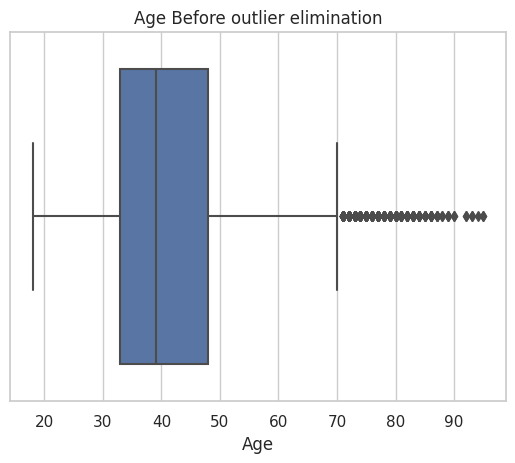

In [153]:
showBoxPlot(df["age"],title="Age Before outlier elimination",xlabel="Age")

In [154]:
ageClipped = maxNMinForOutlierDeduction(df["age"],maintainInt=True)
df["age"] = ageClipped
df

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,cus_converted
0,58,management,married,tertiary,unknown,5,may,261,1,unknown,0
1,44,technician,single,secondary,unknown,5,may,151,1,unknown,0
2,33,entrepreneur,married,secondary,unknown,5,may,76,1,unknown,0
3,47,blue-collar,married,unknown,unknown,5,may,92,1,unknown,0
4,33,unknown,single,unknown,unknown,5,may,198,1,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,cellular,17,nov,977,3,unknown,1
45207,70,retired,divorced,primary,cellular,17,nov,456,2,unknown,1
45208,70,retired,married,secondary,cellular,17,nov,1127,5,success,1
45209,57,blue-collar,married,secondary,telephone,17,nov,508,4,unknown,0


After outlier elimination

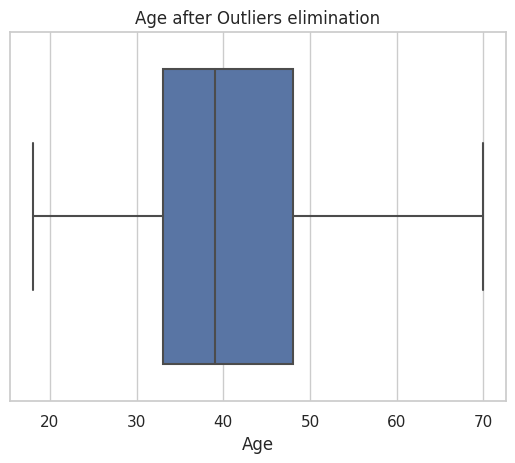

In [155]:
showBoxPlot(df["age"],title="Age after Outliers elimination",xlabel="Age")

##### Duration of call in seconds

In [156]:
df["dur"].dtype

dtype('int64')

In [157]:
df["dur"].min()

0

Implies the dur has reliable values, no negative values to imply missing values

dur feature

- No missing values
- Structured
- int type

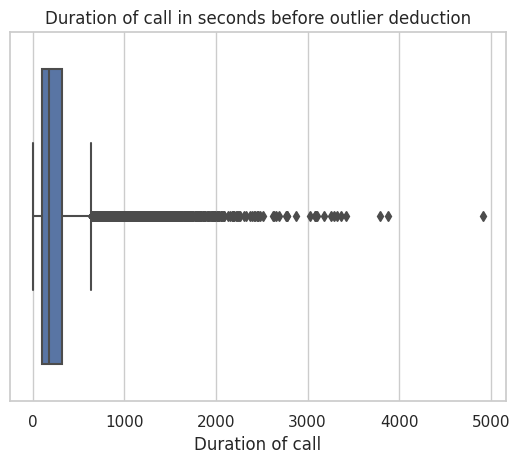

In [158]:
showBoxPlot(df["dur"],title="Duration of call in seconds before outlier deduction",xlabel="Duration of call")

In [159]:
durClipped = maxNMinForOutlierDeduction(df["dur"],maintainInt=True,clipNReturn=True)

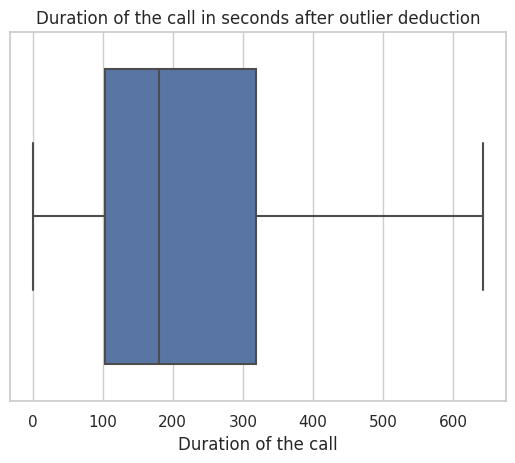

In [160]:
df["dur"] = durClipped
showBoxPlot(feature=df["dur"], title="Duration of the call in seconds after outlier deduction", xlabel="Duration of the call")
plt.show()

##### Number of calls during the campaign

In [161]:
df["num_calls"].dtype

dtype('int64')

All samples are filled, to make sure all the sample have meaningful values like not negative number of calls which may imply the customer did not receive any calls, one need to

In [162]:
df["num_calls"].min()

1

Each customer had at least one call (duration may be 0 but they did get call.)

num_calls feature

- No missing values
- Structured
- int type

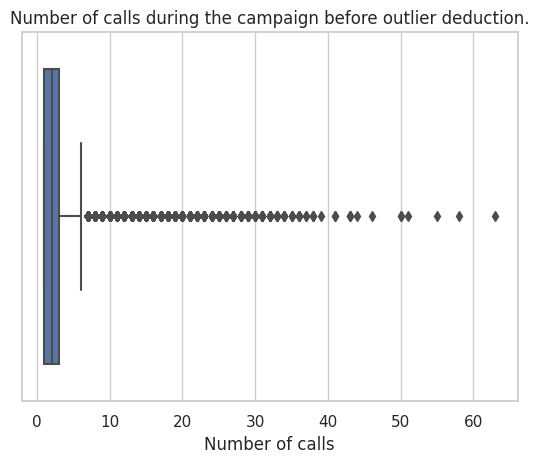

In [163]:
showBoxPlot(df["num_calls"],title="Number of calls during the campaign before outlier deduction.",xlabel="Number of calls")

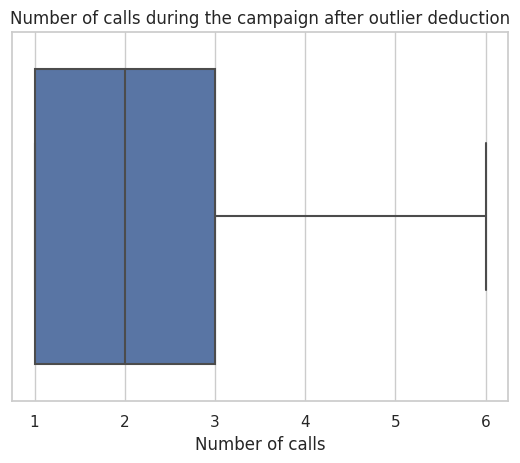

In [164]:
num_callsClipped = maxNMinForOutlierDeduction(df["num_calls"],maintainInt=True)
df["num_calls"] = num_callsClipped
showBoxPlot(df["num_calls"],title="Number of calls during the campaign after outlier deduction",xlabel="Number of calls")

##### Data after continuous variable pre-processing

In [165]:
df

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,cus_converted
0,58,management,married,tertiary,unknown,5,may,261,1,unknown,0
1,44,technician,single,secondary,unknown,5,may,151,1,unknown,0
2,33,entrepreneur,married,secondary,unknown,5,may,76,1,unknown,0
3,47,blue-collar,married,unknown,unknown,5,may,92,1,unknown,0
4,33,unknown,single,unknown,unknown,5,may,198,1,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,cellular,17,nov,643,3,unknown,1
45207,70,retired,divorced,primary,cellular,17,nov,456,2,unknown,1
45208,70,retired,married,secondary,cellular,17,nov,643,5,success,1
45209,57,blue-collar,married,secondary,telephone,17,nov,508,4,unknown,0


#### Processing categorical features

##### Job

In [166]:
df["job"].value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

In [167]:
misPerOfJob = showPercentageOfMissingValues(df["job"],tot=df.shape[0],labelRepresentingUnknownValue="unknown")
misPerOfJob

0.6370131162770122

There are 288 unknown values which is less than 1%. Either can be imputed or removed. Missing values in Job is type of Missing at random. People may refused to say their occupation, we can use education qual to some what estimate the unknown values, but if **edu qual have higher missing values** than removing job's missing values and use jobs to predict to education

Though by general knowledge, there is relation between edu qual. It must be proven graphically. I suspect blue collar jobs tend to have secondary or primary education and white collar must have tertiary.

In [168]:
df

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,cus_converted
0,58,management,married,tertiary,unknown,5,may,261,1,unknown,0
1,44,technician,single,secondary,unknown,5,may,151,1,unknown,0
2,33,entrepreneur,married,secondary,unknown,5,may,76,1,unknown,0
3,47,blue-collar,married,unknown,unknown,5,may,92,1,unknown,0
4,33,unknown,single,unknown,unknown,5,may,198,1,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,cellular,17,nov,643,3,unknown,1
45207,70,retired,divorced,primary,cellular,17,nov,456,2,unknown,1
45208,70,retired,married,secondary,cellular,17,nov,643,5,success,1
45209,57,blue-collar,married,secondary,telephone,17,nov,508,4,unknown,0


Checking relation between jobs and education qualification.

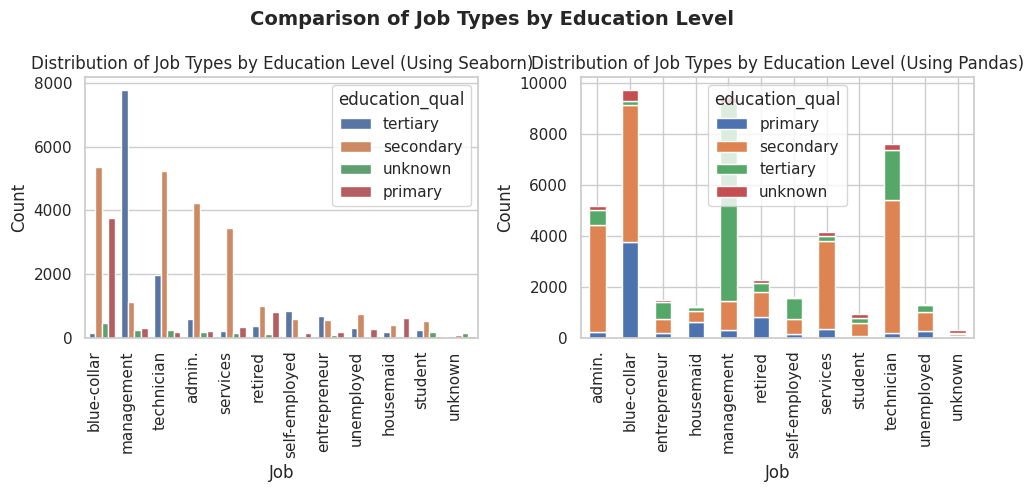

In [169]:

sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))

sns.countplot(x="job", hue="education_qual", data=df, order=df['job'].value_counts().index, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha='right')
ax1.set_xlabel('Job')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Job Types by Education Level (Using Seaborn)')

pivot = pd.pivot_table(df, values='age', index='job', columns='education_qual', aggfunc='count')
pivot.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_xlabel('Job')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of Job Types by Education Level (Using Pandas)')

fig.suptitle('Comparison of Job Types by Education Level', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()



From the above plots we can assume/conclude following things.


- Blue collar jobs are more likely to have higher missing values than white collar jobs because it is Missing at random. People at lower positions are most likely dont reveal the educational background.
- As per general knowledge, most white color jobs demands tertiary education.



Checking relationship between education and age.

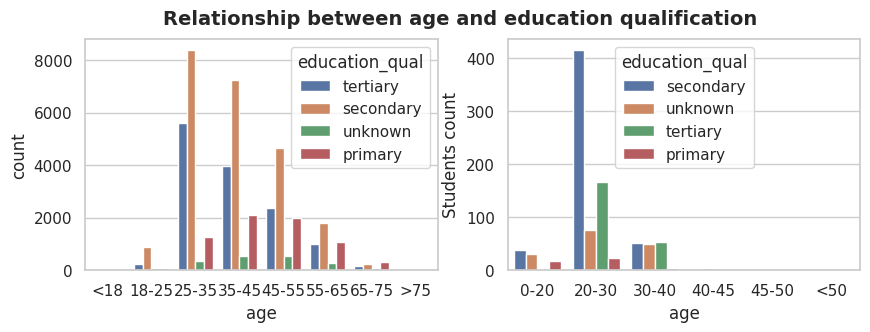

In [170]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(10,3))

age_cat= pd.cut(df['age'], bins=[0, 18, 25, 35, 45, 55, 65, 75, 100], labels=['<18', '18-25', '25-35', '35-45', '45-55', '55-65', '65-75', '>75'])
sns.countplot(x=age_cat, hue="education_qual", data=df,ax=ax1)

studentDf = df[df["job"] == "student"]
student_cut = pd.cut(studentDf["age"],bins=[0,20,30,40,45,50,75],labels=["0-20","20-30","30-40","40-45","45-50","<50"])
sns.countplot(x=student_cut, hue="education_qual", data=studentDf,ax=ax2)
ax2.set_ylabel('Students count')
plt.suptitle('Relationship between age and education qualification', fontsize=14, fontweight='bold')

plt.show()


Inference:
- The max age of currently enrolled in students class of job is 48. 
- Most tertiary holders are in age of 25-55. 
- Most people tend to do their tertiary education in their 20's and 30's **(younger years)** and this claim can be proven by the second graph : count of tertiary students is higher in age group of 20-40.
- So, population of higher educated individuals have a decreasing trend with age of 25 - 55. 
- Unknown trend follow similar trend as primary from first graph

Checking relationship between education qualification and marital status

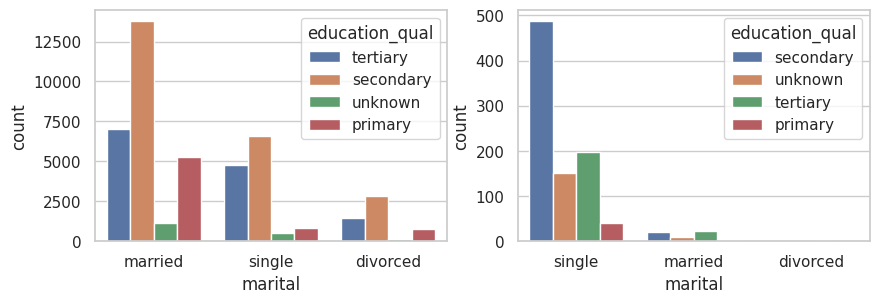

In [171]:
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(10,3))

sns.countplot(x="marital", hue="education_qual",data=df,ax = ax1)
marriedNStudentCon = (df["job"] == "student")
sns.countplot(x="marital", hue="education_qual", data=df[marriedNStudentCon],ax=ax2)
plt.show()

Inference
- There is decreasing trend in the relationship between marital status (from married to divorced ) and the qualification among all classes of marriage.
- Married dominate both tertiary and secondary qualification. This can be accounted for there more marriage population dataset.
- In second graph, most students are not married during education phase which attributes as per general knowledge.
- Unknown pattern also a decreasing trend.

In [172]:
if(showPercentageOfMissingValues(df["job"],tot=df.shape[0]) < showPercentageOfMissingValues(df["education_qual"],tot=df.shape[0])):
    print("We can use job to predict education_qual")
else:
    print("We can use education_qual to predict job")

We can use job to predict education_qual


**Given these conclusion we can remove jobs samples with missing values and use the jobs to estimate education_qual**

We found job, age, profession have relationship with education qual, so we can use them to predict missing values in the education_qual column using **KnnImputer after encoding**

In [173]:
con_For_Job_Section2 = df["job"] != "unknown"
df = df[con_For_Job_Section2]
df.shape

(44923, 11)

In [174]:
df[df["job"] == "unknown"]

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,cus_converted


Job_feature
  - Removed missing values
  - Not encoded
  - structured

##### Martial,Month,day

In [175]:
df["marital"].dtype,df["mon"].dtype,df['day'].dtype

(dtype('O'), dtype('O'), dtype('int64'))

In [176]:
df["marital"].unique(),df["mon"].unique(),df['day'].unique()

(array(['married', 'single', 'divorced'], dtype=object),
 array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
        'mar', 'apr', 'sep'], dtype=object),
 array([ 5,  6,  7,  8,  9, 12, 13, 14, 15, 16, 19, 20, 21, 23, 26, 27, 28,
        29, 30,  2,  3,  4, 11, 17, 18, 24, 25,  1, 10, 22, 31]))

##### Call type

In [177]:
df["call_type"].unique()
showPercentageOfMissingValues(df["call_type"],tot=df.shape[0])

28.73583687643301

There are more than 28% of samples in call_type feature have missing values. 

- Imputation ends up in bias
- Removal ends up losing data.


In [178]:
showPercentageOfMissingValues(df["prev_outcome"],tot=df.shape[0])

81.70424949357789

More than 81% of data are missing

educational_qual preprocessed after EDA

### 3. Explanatory data analysis

#### Distribution and Univariate analysis 

##### Helper functions

In [179]:
def replaceUnknownWithNan(df:pd.DataFrame,featureName:str,missingStrName:str = "unknown"):
    newDf = df.copy()
    newFeatureSeries = newDf[featureName]
    newFeatureSeries.replace(to_replace=missingStrName,value=np.nan,inplace=True)
    newDf[featureName] = newFeatureSeries
    return newDf

In [180]:
def featureVsCus_converted(featureName:str,hspace=1.2,figSize=(15,5),difDf:pd.DataFrame = None) -> None:

    if(difDf is not None):
        newDf = difDf
    else:
        newDf = df
    
    fig,((ax0,ax1,ax2)) = plt.subplots(ncols=3,nrows=1,figsize=figSize,)
    #fig.supxlabel(f"{featureName.capitalize() }",fontsize=20)
    fig.supylabel("People Count")
    #plt.subplots_adjust(hspace=hspace)

    newDf[featureName].value_counts().sort_values(ascending=False).plot(kind="bar",title=f"{featureName} distribution plot",ax=ax0)

    grouped:pd.Series = newDf.groupby(by=[featureName,"cus_converted"]).size()
    grouped1:pd.DataFrame = grouped.unstack().sort_values(ascending=False,by=1)
    grouped1.plot(kind="bar",title=f"{featureName} vs cus_converted (Yes and No)",ax=ax1,xlabel=None)
    ax1.legend(['Did not convert', 'Converted'])

    subC = "Subscribed_counts"
    grouped2 = grouped.reset_index(name=subC)
    con = grouped2["cus_converted"] == 1
    grouped2 = grouped2[con]
    grouped2.drop(columns=["cus_converted"],axis=1,inplace=True)
    grouped2.sort_values(by=subC,ascending=False,inplace=True)
    grouped2.plot(kind="bar",x=featureName,y=subC,legend=True,title=f"{featureName} vs {subC}",ax=ax2,xlabel=None,color="#af7f0e")

        

    #map(lambda x: x.set_xlabel(""),[ax0,ax1,ax2,ax3])  
    ax0.set_xlabel("")
    ax1.set_xlabel("")
    ax2.set_xlabel("")
    plt.show() 

    

In [181]:
def encodeByPattern(featureName:str,mapPattern:dict):
    encoded_feature = df[featureName].copy()
    encoded_feature = encoded_feature.map(mapPattern)
    df[featureName] = encoded_feature 

##### education_qual vs target

Replacing unknown with np.nan

In [182]:
df = replaceUnknownWithNan(df,"education_qual")

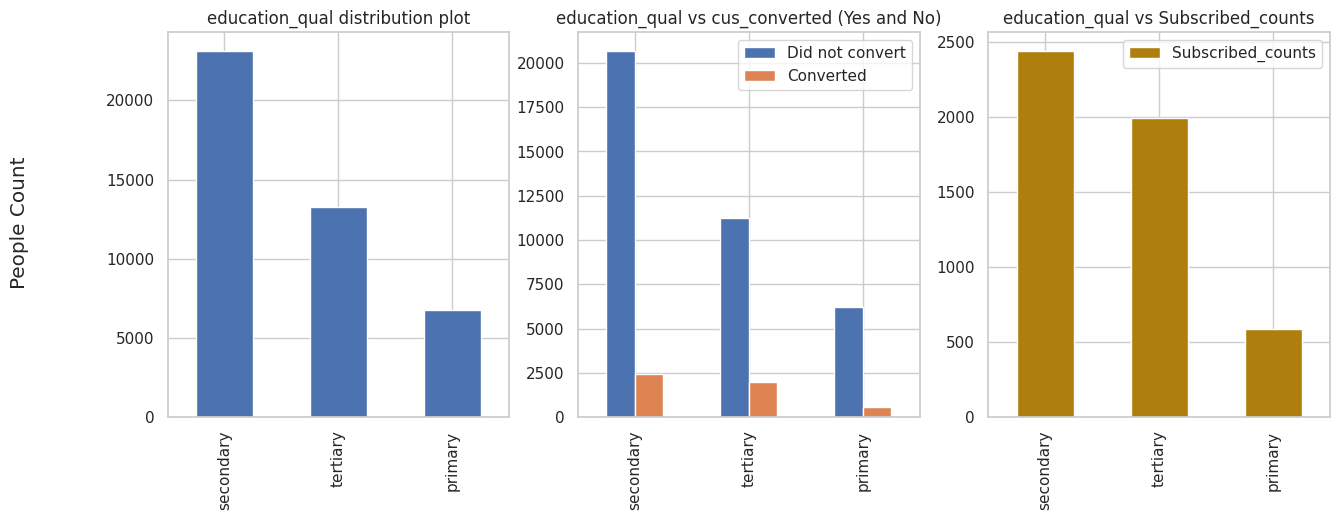

In [183]:
featureVsCus_converted("education_qual")

Inference:

- Mostly **secondary** education qualified people where contacted, (which is not necessarily intentional).
- **Primary** education qualified where least contacted
- Most Subscribed -> secondary
- Least Subscribed -> primary


Encoding

Must skip 2 to reflect the discrepancy between tertiary and primary, but lets encode education_qual and decide about skipping process

In [184]:
encodeByPattern(featureName="education_qual",mapPattern={"primary":1,'tertiary':2,'secondary':3})
df["education_qual"].unique()

array([ 2.,  3., nan,  1.])

In [185]:
df.head(5)

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,cus_converted
0,58,management,married,2.0,unknown,5,may,261,1,unknown,0
1,44,technician,single,3.0,unknown,5,may,151,1,unknown,0
2,33,entrepreneur,married,3.0,unknown,5,may,76,1,unknown,0
3,47,blue-collar,married,NaN,unknown,5,may,92,1,unknown,0
5,35,management,married,2.0,unknown,5,may,139,1,unknown,0


##### marital vs target

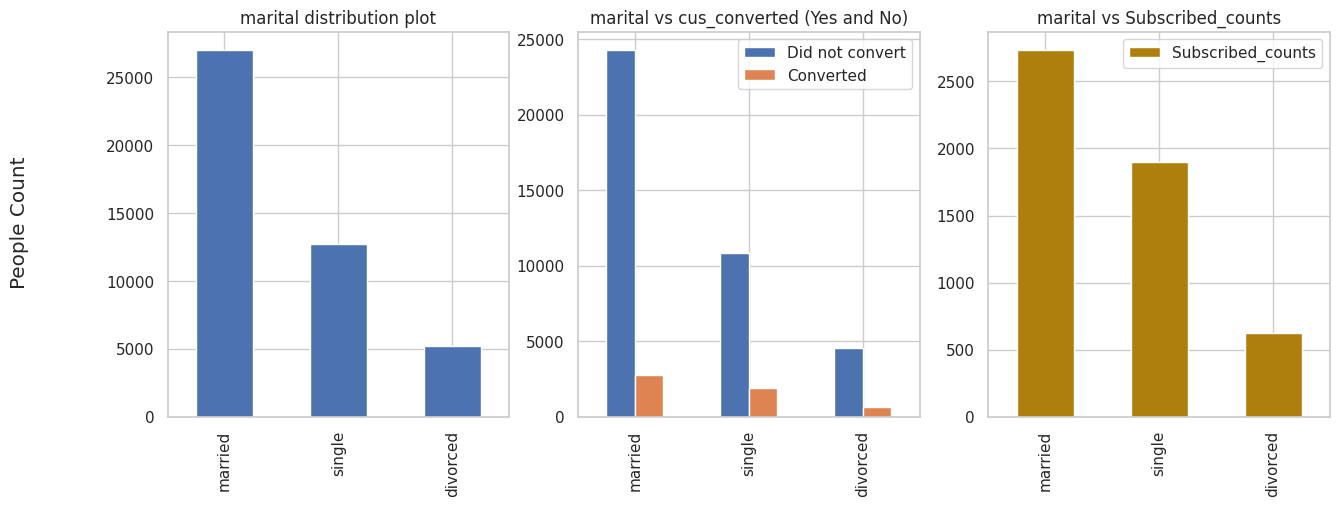

In [186]:
featureVsCus_converted("marital")

Inference
- Married men/women were more contacted.
- Most subscribed are "married"
- Least subscribed are "divorced"

Encoding

Skipping 2 to reflect difference between single and divorced.

In [187]:
encodeByPattern("marital", mapPattern={"married":4,"single":3,"divorced":1})
df["marital"].unique()

array([4, 3, 1])

In [188]:
df.head(3)

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,cus_converted
0,58,management,4,2.0,unknown,5,may,261,1,unknown,0
1,44,technician,3,3.0,unknown,5,may,151,1,unknown,0
2,33,entrepreneur,4,3.0,unknown,5,may,76,1,unknown,0


##### jobs vs target

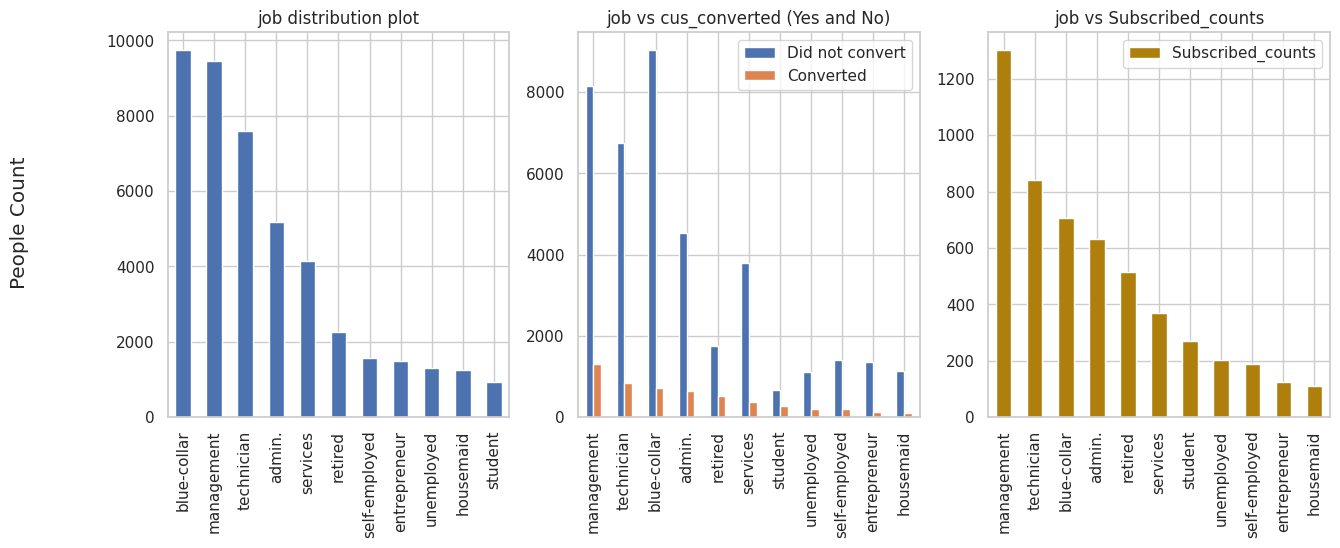

In [189]:
featureVsCus_converted("job")

Inference

  1. Most subscribed are **management** professionals.
  2. Though more blue collars were contacted but they are the most refusers to insure.
  3. Least subscribed are house-maids.


Encoding

Skipping 11 to reflect the difference between "technician" and "management".

In [190]:
df["job"].unique()

array(['management', 'technician', 'entrepreneur', 'blue-collar',
       'retired', 'admin.', 'services', 'self-employed', 'unemployed',
       'housemaid', 'student'], dtype=object)

In [191]:
encodeByPattern("job", mapPattern={"management":12,"technician":10,"blue-collar":9,"admin.":8,'retired':7,'services':6,'student':5,'unemployed':4,'self-employed':3,'entrepreneur':2,'housemaid':1})
df["job"].unique()

array([12, 10,  2,  9,  7,  8,  6,  3,  4,  1,  5])

In [192]:
df.head(3)

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,cus_converted
0,58,12,4,2.0,unknown,5,may,261,1,unknown,0
1,44,10,3,3.0,unknown,5,may,151,1,unknown,0
2,33,2,4,3.0,unknown,5,may,76,1,unknown,0


Finding Missing values in education_qual by job,age,martial status by established relationship in section 

We can use interative-imputer with different hyper parameter to find best hyper parameter and fill the education_field missing values

In [193]:
knnDf = df.loc[:,["age","job","marital","education_qual","cus_converted"]]
knnDf.head(5)

,age,job,marital,education_qual,cus_converted
0,58,12,4,2.0,0
1,44,10,3,3.0,0
2,33,2,4,3.0,0
3,47,9,4,NaN,0
5,35,12,4,2.0,0


In [194]:
(df["education_qual"].isna().sum()/df.shape[0])*100

3.8510339914965606

Imputation by Interative imputer

In [195]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def iterative_imputation(newDf):
    df = newDf.copy()
    X = df[['job', 'marital', 'age','education_qual']]
    imputer = IterativeImputer(max_iter=10, random_state=0, initial_strategy='constant')
    y_imputed = imputer.fit_transform(X)
    df['education_qual'] = (y_imputed[:,3]).astype(int)

    return df

imputedDF = iterative_imputation(knnDf)

In [196]:
def printDifference(df:pd.DataFrame,datasetName:str,featureName:str):
    print(f"{datasetName} dataset")
    print(f"Missing Values: {df[featureName].isna().sum()}\n")
    print(f"Unique Values: {df[featureName].unique()}\n")
    print(f"Value Counts: \n{df[featureName].value_counts()}")
    print(" ","_______","\n")



In [197]:
printDifference(df,"Original dataset","education_qual")
printDifference(imputedDF,"Imputed dataset","education_qual")

Original dataset dataset
Missing Values: 1730

Unique Values: [ 2.  3. nan  1.]

Value Counts: 
3.0    23131
2.0    13262
1.0     6800
Name: education_qual, dtype: int64
  _______ 

Imputed dataset dataset
Missing Values: 0

Unique Values: [2 3 1]

Value Counts: 
3    23131
2    14988
1     6804
Name: education_qual, dtype: int64
  _______ 



Inference
- Tertiary count has been increased,
- Secondary count is unchanged
- Primary count is unchanged.

In [198]:
df["education_qual"] = imputedDF["education_qual"]

Missing Values: 0


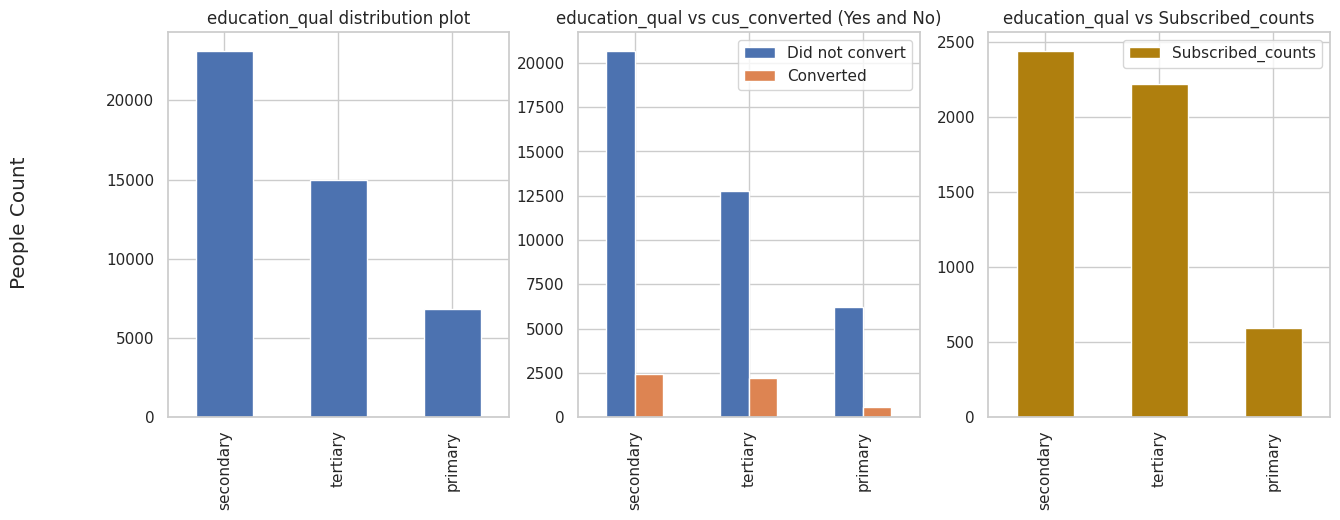

In [199]:
decoded_edu = df.copy()
decoded_edu["education_qual"] = decoded_edu["education_qual"].map({1:"primary",3:"secondary",2:"tertiary"})
print(f"Missing Values: {decoded_edu['education_qual'].isna().sum()}")
featureVsCus_converted("education_qual",difDf=decoded_edu)



Lets encode `{3:4,2:3,1:1}` in original df

In [200]:
df["education_qual"] = df["education_qual"].map({3:4,2:3,1:1})
df

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,cus_converted
0,58,12,4,3,unknown,5,may,261,1,unknown,0
1,44,10,3,4,unknown,5,may,151,1,unknown,0
2,33,2,4,4,unknown,5,may,76,1,unknown,0
3,47,9,4,3,unknown,5,may,92,1,unknown,0
5,35,12,4,3,unknown,5,may,139,1,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...
45206,51,10,4,3,cellular,17,nov,643,3,unknown,1
45207,70,7,1,1,cellular,17,nov,456,2,unknown,1
45208,70,7,4,4,cellular,17,nov,643,5,success,1
45209,57,9,4,4,telephone,17,nov,508,4,unknown,0


##### target vs call_type

In [201]:
showPercentageOfMissingValues(df["call_type"],tot=df.shape[0])

28.73583687643301

Call_type is missing completely random.

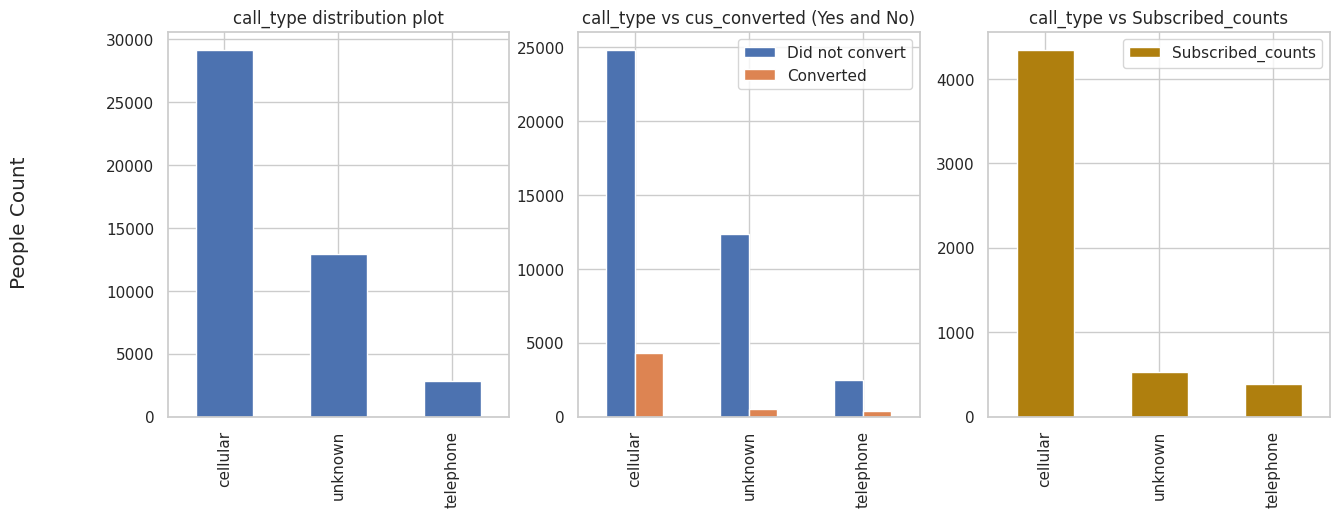

In [202]:
featureVsCus_converted("call_type")

Inference
- Most subscribed => cellular
- least subscribed => unknown
- There is a excess weight on cellular compared to other call_types. 


Encoding

In [203]:
df["call_type"].unique()

array(['unknown', 'cellular', 'telephone'], dtype=object)

In [204]:
encodeByPattern("call_type",{"cellular":3,"unknown":1,"telephone":2})
df

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,cus_converted
0,58,12,4,3,1,5,may,261,1,unknown,0
1,44,10,3,4,1,5,may,151,1,unknown,0
2,33,2,4,4,1,5,may,76,1,unknown,0
3,47,9,4,3,1,5,may,92,1,unknown,0
5,35,12,4,3,1,5,may,139,1,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...
45206,51,10,4,3,3,17,nov,643,3,unknown,1
45207,70,7,1,1,3,17,nov,456,2,unknown,1
45208,70,7,4,4,3,17,nov,643,5,success,1
45209,57,9,4,4,2,17,nov,508,4,unknown,0


Day vs target

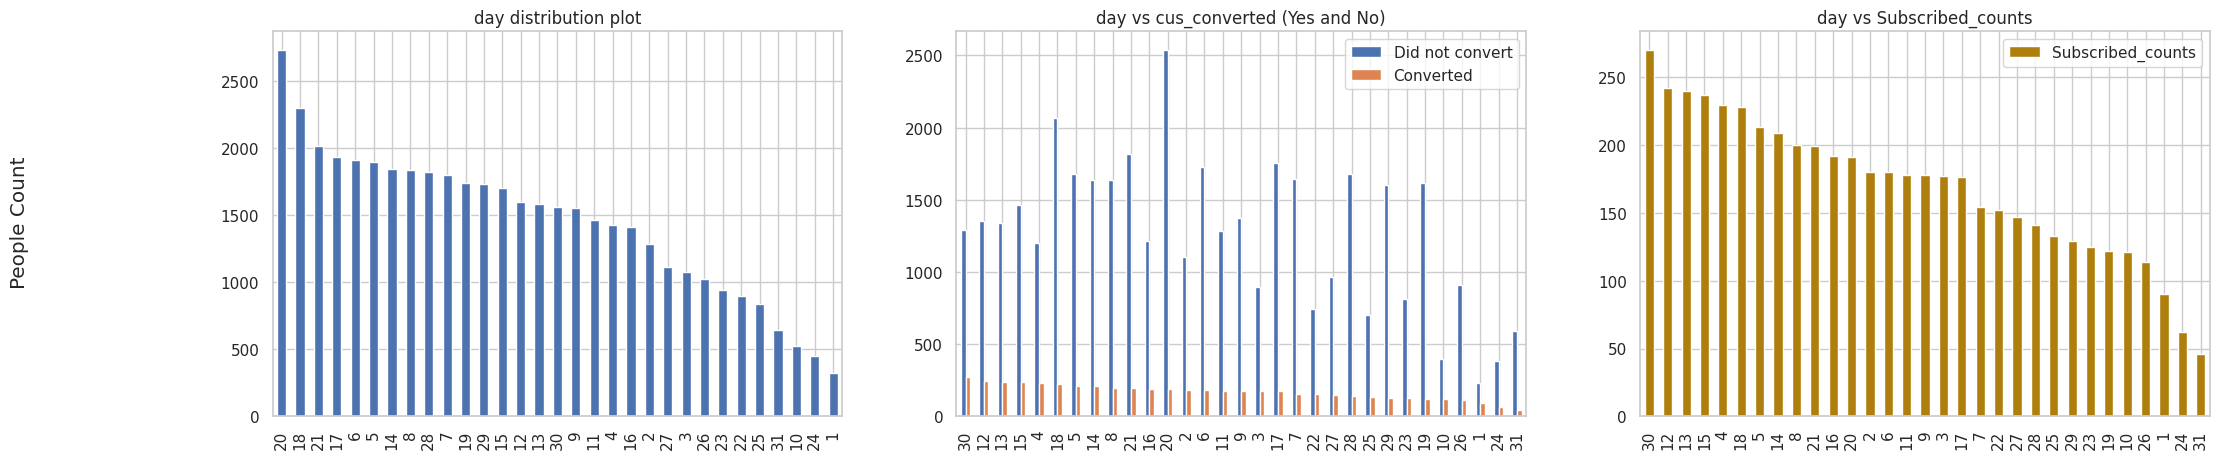

In [205]:
featureVsCus_converted("day",figSize=(25,5))

Inference
- It is interesting to see 30th is most subscribed day in month, it important to note that 31st exists in alternative months.
- Insurance companies might call you at the end of the month because they have sales quotas to meet. Sales representatives may feel the pressure to make sales before the end of the month to meet their targets, so they may reach out to potential customers more frequently during this time.
- People tend to get subscribed in mid-days of months compared to other days (except 31)
- It Would be reasonable to group the day into 1-5,5-10,10-15,15-20 and 20-25 days to see if they are more likely to be subscribed.


In [206]:
grouped_Dates_5X = pd.cut(df["day"].copy(),bins=[0,5,10,15,20,25,32],labels=['1-5', '6-10', '11-15', '16-20', '21-25', '26-31'])
grouped_Dates_5X.unique()

['1-5', '6-10', '11-15', '16-20', '21-25', '26-31']
Categories (6, object): ['1-5' < '6-10' < '11-15' < '16-20' < '21-25' < '26-31']

In [207]:
grouped_Dates_5X[grouped_Dates_5X.isna() == True].size
grouped_Dates_5X_DF = df.copy()
grouped_Dates_5X_DF["day"] = grouped_Dates_5X
grouped_Dates_5X_DF.head(3)

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,cus_converted
0,58,12,4,3,1,1-5,may,261,1,unknown,0
1,44,10,3,4,1,1-5,may,151,1,unknown,0
2,33,2,4,4,1,1-5,may,76,1,unknown,0


In [208]:
grouped_Dates_5X_DF["day"].unique()

['1-5', '6-10', '11-15', '16-20', '21-25', '26-31']
Categories (6, object): ['1-5' < '6-10' < '11-15' < '16-20' < '21-25' < '26-31']

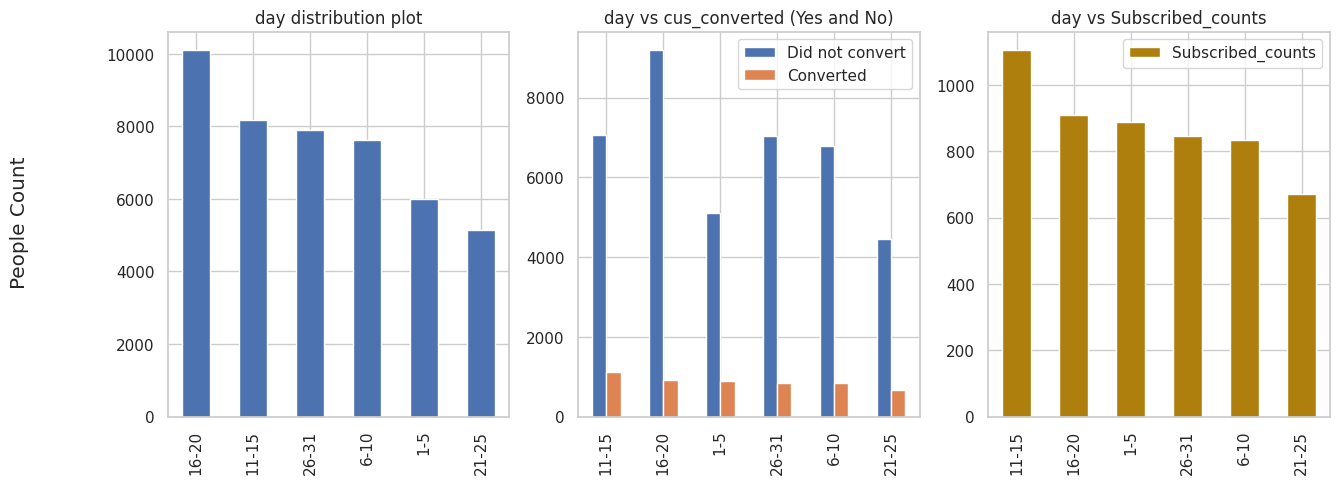

In [209]:
featureVsCus_converted("day",difDf=grouped_Dates_5X_DF)

Inference
- In mid-days of months most people getting subscribed cause mid-days most people were contacted.
- To clearly see this effect lets minimize into three groups
- Lets do `[0-10, 11-20,20-31]` .

In [210]:
grouped_Dates_10X = pd.cut(df["day"].copy(),bins=[0,10,20,32],labels=["1-10", '11-20', '21-31'])
grouped_Dates_10X_DF = df.copy()
grouped_Dates_10X_DF["day"] = grouped_Dates_10X
grouped_Dates_10X_DF.head(3)

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,cus_converted
0,58,12,4,3,1,1-10,may,261,1,unknown,0
1,44,10,3,4,1,1-10,may,151,1,unknown,0
2,33,2,4,4,1,1-10,may,76,1,unknown,0


In [211]:
grouped_Dates_10X_DF["day"].unique()

['1-10', '11-20', '21-31']
Categories (3, object): ['1-10' < '11-20' < '21-31']

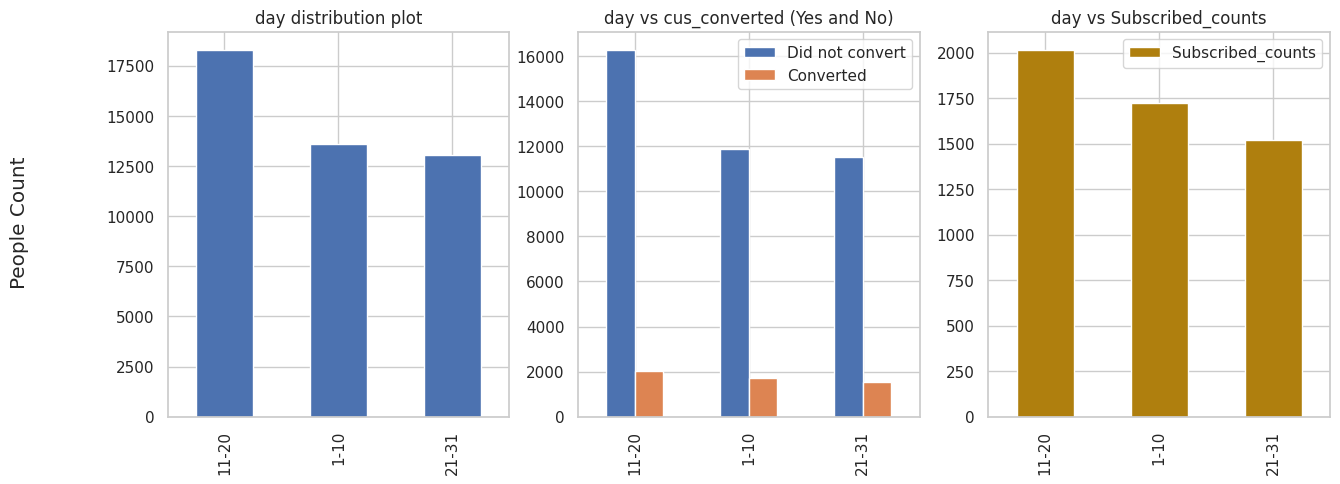

In [212]:
featureVsCus_converted("day",difDf=grouped_Dates_10X_DF)

Inference 
- we can clearly see the “mid-month” effect.
- Most subscribed -> mid month (11-20)
- Least subscribed -> end of the month (21-31)

30th was the most subscribed day of month. Lets see how many seconds each person conversed in 30th.

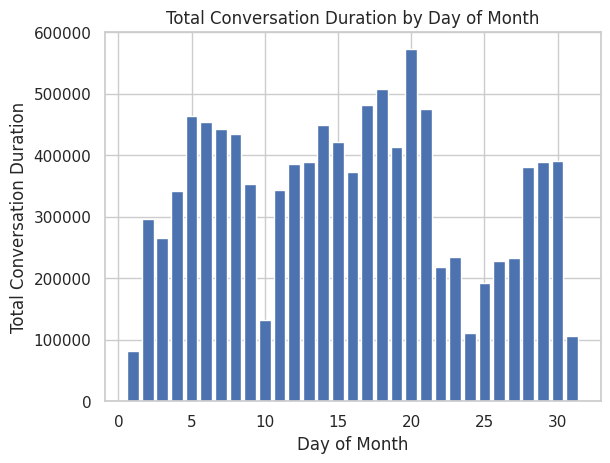

In [213]:
def totConvOfdayInMonth():
    daily_conversation_duration = df.groupby("day")["dur"].sum()
    fig, ax = plt.subplots()
    ax.bar(daily_conversation_duration.index, daily_conversation_duration.values)
    ax.set_xlabel("Day of Month")
    ax.set_ylabel("Total Conversation Duration")
    ax.set_title("Total Conversation Duration by Day of Month")
    plt.show()
totConvOfdayInMonth()

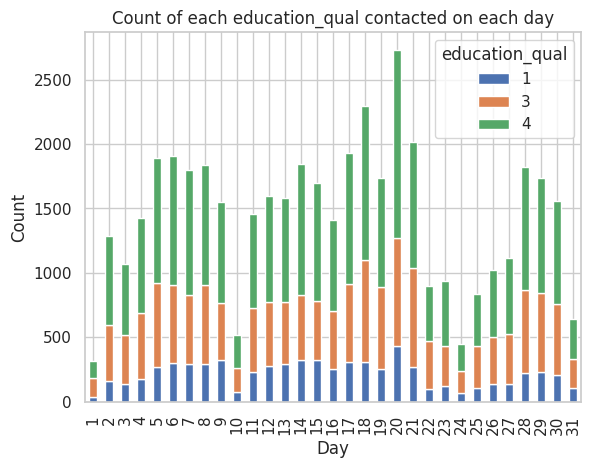

In [214]:
def ContactedEduQualEachDay():
    grouped = df.groupby(['day', 'education_qual']).size().reset_index(name='count')


    pivoted = grouped.pivot(index='day', columns='education_qual', values='count')

    # Create a stacked bar plot of the counts
    pivoted.plot(kind='bar', stacked=True)
    plt.xlabel('Day')
    plt.ylabel('Count')
    plt.title('Count of each education_qual contacted on each day')
    plt.show()

ContactedEduQualEachDay()

Inference
- On the 20th of the month, both the duration and education qualification of contacted people were dominant.
- The 30th of the month was the most subscribed day, despite not being in the top 5 for duration vs. day and day vs. education qualification.
- Other factors may be at play, which could be contributing to unexplained variance associated with the 30th of the day.
- It is possible that this could be due to chance and not statistically significant

Encoding

Lets Encode the day column to `11-20:3, 1-10:2, 21-31:3`

In [215]:
df["day"] = pd.cut(df["day"].copy(),bins=[0,10,20,32],labels=["1-10", '11-20', '21-31'])

In [216]:
df["day"] = df["day"].map({'11-20':3,"1-10":2,"21-31":3})

In [217]:
df

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,cus_converted
0,58,12,4,3,1,2,may,261,1,unknown,0
1,44,10,3,4,1,2,may,151,1,unknown,0
2,33,2,4,4,1,2,may,76,1,unknown,0
3,47,9,4,3,1,2,may,92,1,unknown,0
5,35,12,4,3,1,2,may,139,1,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...
45206,51,10,4,3,3,3,nov,643,3,unknown,1
45207,70,7,1,1,3,3,nov,456,2,unknown,1
45208,70,7,4,4,3,3,nov,643,5,success,1
45209,57,9,4,4,2,3,nov,508,4,unknown,0


##### target vs mon

In [218]:
showPercentageOfMissingValues(df["mon"],tot=df.shape[0]),df["mon"].isna().sum()

(0.0, 0)

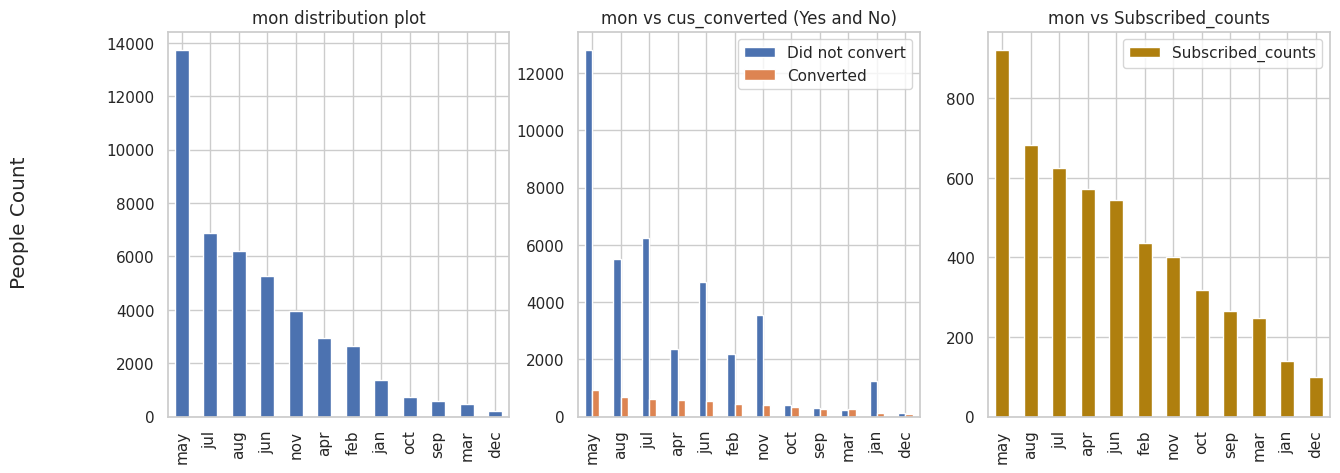

In [219]:
featureVsCus_converted("mon")

Inference
- May month has more weight
- Most subscribed month -> May
- Least subscribed month -> december
- Fairly decreasing trend.

In [220]:
df["mon"].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr', 'sep'], dtype=object)

Lets encode `{dec:1,jan:2,mar:3,sep:4,oct:5,nov:6,feb:7,jun:8,apr:9,jul:10,aug:11,may:12}`

In [221]:
encodeByPattern("mon",{"dec":1,"jan":2,"mar":3,"sep":4,"oct":5,"nov":6,"feb":7,"jun":8,"apr":9,"jul":10,"aug":11,"may":12})

In [222]:
df["mon"].unique()

array([12,  8, 10, 11,  5,  6,  1,  2,  7,  3,  9,  4])

In [223]:
df["mon"].isna().sum()

0

In [224]:
df.head()

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,cus_converted
0,58,12,4,3,1,2,12,261,1,unknown,0
1,44,10,3,4,1,2,12,151,1,unknown,0
2,33,2,4,4,1,2,12,76,1,unknown,0
3,47,9,4,3,1,2,12,92,1,unknown,0
5,35,12,4,3,1,2,12,139,1,unknown,0


prev_outcome vs target

In [225]:
showPercentageOfMissingValues(df["prev_outcome"],tot=df.shape[0]),df["prev_outcome"].isna().sum()

(81.70424949357789, 0)

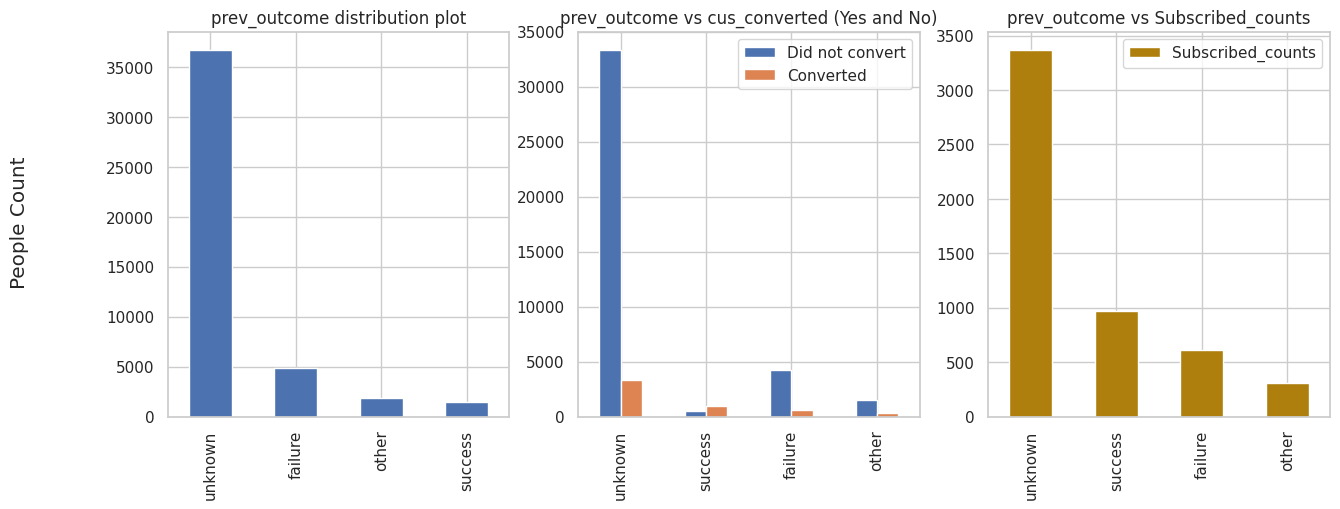

In [226]:
featureVsCus_converted("prev_outcome")

Inference:
- Fair amount of data is missing
- unknown prev_outcome people have more subscribed people.
- least was other


**Unknown whatever it is must fall under other if it is not success or failure, so skipping 3 does not makes sense**

Encoding

`{success:4,failure:3,other:2,unknown:1}`

In [227]:
encodeByPattern("prev_outcome",mapPattern={"success":4,"failure":3,"other":2,"unknown":1})

In [228]:
df["prev_outcome"].unique()

array([1, 3, 2, 4])

In [229]:
df["prev_outcome"].isna().sum()

0

In [230]:
df.head()

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,cus_converted
0,58,12,4,3,1,2,12,261,1,1,0
1,44,10,3,4,1,2,12,151,1,1,0
2,33,2,4,4,1,2,12,76,1,1,0
3,47,9,4,3,1,2,12,92,1,1,0
5,35,12,4,3,1,2,12,139,1,1,0


### Splitting and Scaling

#### Splitting

In [233]:

x = df[['age', 'job', 'marital', 'education_qual', 'call_type', 'day', 'mon', 'dur', 'num_calls', 'prev_outcome']].values
y=df['cus_converted'].values

In [234]:

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state = 3 )

#### Balancing and scaling

In [235]:
from imblearn.combine import SMOTEENN 
smt = SMOTEENN(sampling_strategy='all') 
x_train_smt, y_train_smt = smt.fit_resample(x_train, y_train)

In [236]:
print(len(x_train_smt))
print(len(y_train_smt))

52055
52055


In [237]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_smt)
x_test_scaled = scaler.transform(x_test)

### Modeling

#### Logistic Regression

In [238]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

lr = LogisticRegression()

lr.fit(x_train_scaled,y_train_smt)
lr.score(x_test_scaled,y_test)

0.742014468558709

In [239]:
y_pred=lr.predict_proba(x_test_scaled)
y_pred

array([[0.56451474, 0.43548526],
       [0.00920666, 0.99079334],
       [0.93049644, 0.06950356],
       ...,
       [0.18725245, 0.81274755],
       [0.618032  , 0.381968  ],
       [0.93449216, 0.06550784]])

In [240]:
log_reg_auroc = roc_auc_score(y_test,y_pred[:,1])
print("AUROC score for logistic regression  :  ",round(log_reg_auroc,2))

AUROC score for logistic regression  :   0.87


#### KNN

In [241]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import cross_val_score 
for i in [1,2,3,4,5,6,7,8,9,10,20,30,40,50]: 
    knn= KNeighborsClassifier(i)
    knn.fit(x_train_scaled, y_train_smt) 
    print("K value :", i, "Train Score : ", knn.score(x_train_scaled,y_train_smt), "Cross Value Accuracy :" , np.mean(cross_val_score(knn, x_test_scaled, y_test, cv=10)))

K value : 1 Train Score :  1.0 Cross Value Accuracy : 0.8658879824402763
K value : 2 Train Score :  0.9794832388819518 Cross Value Accuracy : 0.8854768104129558
K value : 3 Train Score :  0.965094611468639 Cross Value Accuracy : 0.8831387758236694
K value : 4 Train Score :  0.9602919988473729 Cross Value Accuracy : 0.8887036078196264
K value : 5 Train Score :  0.9540678128902123 Cross Value Accuracy : 0.89026039821529
K value : 6 Train Score :  0.9516665065795793 Cross Value Accuracy : 0.8918169408721891
K value : 7 Train Score :  0.9469407357602536 Cross Value Accuracy : 0.8907036028648511
K value : 8 Train Score :  0.9459802132360003 Cross Value Accuracy : 0.8899259508833126
K value : 9 Train Score :  0.9441936413408895 Cross Value Accuracy : 0.8899264463608414
K value : 10 Train Score :  0.942253385841898 Cross Value Accuracy : 0.890928301924187
K value : 20 Train Score :  0.9319181634809336 Cross Value Accuracy : 0.8877015045175165
K value : 30 Train Score :  0.9265008164441456 Cro

In [242]:
knn= KNeighborsClassifier(i)
knn.fit(x_train_scaled, y_train_smt)
print("KNN Score: ",knn.score(x_test_scaled,y_test)) 
print( "AUROC on the sampled dataset : ",roc_auc_score( y_test, knn.predict_proba(x_test)[:, 1]))


KNN Score:  0.7754034501947691
AUROC on the sampled dataset :  0.5101918904140166


**Best Values**

K parameter = 9
AUROC Score = 0.8899

#### Decision Tree

In [243]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import roc_auc_score

In [244]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import roc_auc_score 
dt = DecisionTreeClassifier() 
dt.fit(x_train_smt,y_train_smt) 
print("Decision Tree Score : ", dt.score(x_train_smt,y_train_smt)) 
print( "AUROC on the sampled dataset : ",roc_auc_score( y_test, dt.predict_proba(x_test)[:, 1]))

Decision Tree Score :  1.0
AUROC on the sampled dataset :  0.776346210207844


In [245]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score 
import numpy as np

for depth in [1,2,3,4,5,6,7,8,9,10,20]:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(x_train_smt, y_train_smt) 
    trainAccuracy = accuracy_score(y_train_smt, dt.predict(x_train_smt))
    dt = DecisionTreeClassifier(max_depth=depth)
    valAccuracy = cross_val_score(dt, x_test_scaled, y_test, cv=10)
    print("Depth  : ", depth, " Training Accuracy : ", trainAccuracy, " Cross val score : " ,np.mean(valAccuracy))

Depth  :  1  Training Accuracy :  0.792181346652579  Cross val score :  0.8822482788349342
Depth  :  2  Training Accuracy :  0.792181346652579  Cross val score :  0.886922118364627
Depth  :  3  Training Accuracy :  0.8522140044184036  Cross val score :  0.8966037492784608
Depth  :  4  Training Accuracy :  0.8740754970704063  Cross val score :  0.8967148601143066
Depth  :  5  Training Accuracy :  0.8884064931322639  Cross val score :  0.897162771800392
Depth  :  6  Training Accuracy :  0.9094227259629238  Cross val score :  0.89827499498329
Depth  :  7  Training Accuracy :  0.9157429641725099  Cross val score :  0.8946016484537385
Depth  :  8  Training Accuracy :  0.9259821342810489  Cross val score :  0.8930423806704306
Depth  :  9  Training Accuracy :  0.9339736816828355  Cross val score :  0.8909279303160403
Depth  :  10  Training Accuracy :  0.9451349534146576  Cross val score :  0.887365323014188
Depth  :  20  Training Accuracy :  0.9981750072039189  Cross val score :  0.8635475943


**Best Values**

Depth parameter = 6

AUROC Score = 0.898

In [246]:
dt = DecisionTreeClassifier(max_depth=5) 
dt.fit(x_train_smt,y_train_smt) 
print("Decision Tree Score : ", dt.score(x_train_smt,y_train_smt)) 
print( "AUROC on the sampled dataset : ",roc_auc_score( y_test, dt.predict_proba(x_test)[:, 1]))

Decision Tree Score :  0.8884064931322639
AUROC on the sampled dataset :  0.8728056201878054


#### XGBoost

In [247]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score 
import numpy as np 
for lr in [0.01,0.02,0.03,0.04,0.05,0.1,0.11,0.12,0.13,0.14,0.15,0.2,0.5,0.7,1]: 
    model = xgb.XGBClassifier(learning_rate = lr, n_estimators=100, verbosity = 0) 
    model.fit(x_train_smt,y_train_smt) 
    print("Learning rate : ", lr," Train score : ", model.score(x_train_smt,y_train_smt)," Cross-Val score : ", np.mean(cross_val_score(model, x_test, y_test, cv=10)))
        

Learning rate :  0.01  Train score :  0.9256747670732879  Cross-Val score :  0.8983858580803714
Learning rate :  0.02  Train score :  0.9313034290654116  Cross-Val score :  0.8992767266772533
Learning rate :  0.03  Train score :  0.9378734031313034  Cross-Val score :  0.9003895692070625
Learning rate :  0.04  Train score :  0.9432907501680915  Cross-Val score :  0.9015022878674894
Learning rate :  0.05  Train score :  0.9474978388243205  Cross-Val score :  0.9011678405355121
Learning rate :  0.1  Train score :  0.9582364806454712  Cross-Val score :  0.9021701915763864
Learning rate :  0.11  Train score :  0.9595427912784554  Cross-Val score :  0.9022798159796457
Learning rate :  0.12  Train score :  0.9612717318221112  Cross-Val score :  0.9007225301064533
Learning rate :  0.13  Train score :  0.9608298914609548  Cross-Val score :  0.9025026569982485
Learning rate :  0.14  Train score :  0.9625588320046105  Cross-Val score :  0.9006115431399897
Learning rate :  0.15  Train score :  0.9


**Best Values**

Learning rate eta = 0.13

AUROC Score = 0.902

#### Random Forest

In [248]:
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(max_depth=2,n_estimators=100,max_features="sqrt")    #max_depth=log(no of features)
rf.fit(x_train, y_train)
y_pred= rf.predict(x_test)

In [249]:

from sklearn.model_selection import cross_val_score 
from sklearn.ensemble import RandomForestClassifier
for depth in [1,2,3,4,5,6,7,8,9,10]:
    rf= RandomForestClassifier(max_depth=depth,n_estimators=100,max_features="sqrt")   
    rf.fit(x_train, y_train) 
    rf= RandomForestClassifier(max_depth=depth,n_estimators=100,max_features="sqrt")   
    valAccuracy = cross_val_score(rf, x_train, y_train, cv=10) 
    print("Depth  : ", depth, " Training Accuracy : ", trainAccuracy, " Cross val score : " ,np.mean(valAccuracy))

Depth  :  1  Training Accuracy :  0.9981750072039189  Cross val score :  0.8832155472653576
Depth  :  2  Training Accuracy :  0.9981750072039189  Cross val score :  0.8842173173862923
Depth  :  3  Training Accuracy :  0.9981750072039189  Cross val score :  0.8894206272909623
Depth  :  4  Training Accuracy :  0.9981750072039189  Cross val score :  0.8948466930303018
Depth  :  5  Training Accuracy :  0.9981750072039189  Cross val score :  0.8957370736179187
Depth  :  6  Training Accuracy :  0.9981750072039189  Cross val score :  0.8969058196229884
Depth  :  7  Training Accuracy :  0.9981750072039189  Cross val score :  0.8982413711444422
Depth  :  8  Training Accuracy :  0.9981750072039189  Cross val score :  0.8993544920787514
Depth  :  9  Training Accuracy :  0.9981750072039189  Cross val score :  0.9003282986565264
Depth  :  10  Training Accuracy :  0.9981750072039189  Cross val score :  0.9002169788191068




**Best Values**

depth 9

Score 0.90




### Models and AROUC Score

*   **Logistic Regression** - AUROC Score is **0.87** 
*   **KNN** - AUROC Score is  **0.889**
*   **Decision Tree** - AUROC Score is **0.898**
*   **XG Boost** - AUROC Score is  **0.902**
*   **Random Forest** - AUROC Score is **0.90**

### Feature Importance

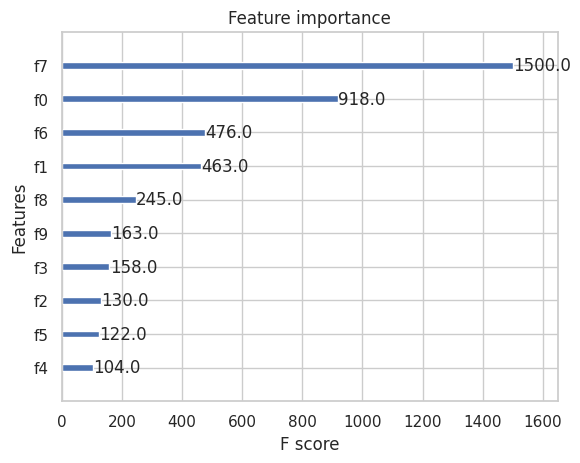

In [250]:
from xgboost import plot_importance

plot_importance(model)
plt.show()

In [251]:
df.columns

Index(['age', 'job', 'marital', 'education_qual', 'call_type', 'day', 'mon',
       'dur', 'num_calls', 'prev_outcome', 'cus_converted'],
      dtype='object')

Features

- f0 - Age, 
- f1 - Job, 
- f2 - marital status,
- f3- educational qualification, 
- f4 - call type, 
- f5 - day, 
- f6 - mon, 
- f7 -dur, 
- f8 - number of calls, 
- f9 - previous outcome 

### Conclusion

Top five features need to considered in order to improve the growth of the company
1. Time the call lasts(dur) - The call that last more is more probable to get insured according to the model
2. Age - Middle aged man are more suspectible to conversion.
3. Month - More conversion during may month of the year
4. Job - Most white collar who are more educated about insurance are suspectible to conversion
5. Number of calls - Repeated calls to customers helps company for getting more people subscribed.
